# Вебинар 3. Коллаборативная фильтрация

Исчерпывающую информацию с теорией, кодом и примерами можно найти в [статье](https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/)

# 1. Матричная факторизация

Раскладываем user-item матрицу на 2: матрицу латентных факторов юзеров и матрицу латентных факторов товаров

- латентые факторы = эмбеддинг (embedding)    

$$S_{(m,n)} = U_{(m,k)}\cdot \Sigma_{(k,k)}\cdot V_{(k,n)}= U_{(m,k)}\cdot \Sigma_{u,(k,k)}\cdot \Sigma_{v,(k,k)}\cdot V_{(k,n)}=U'_{(m,k)}\cdot V'_{(k,n)}$$

S(m,n)=> X(n,n), S(m,n) @ X(n,n)=S'(m,n)

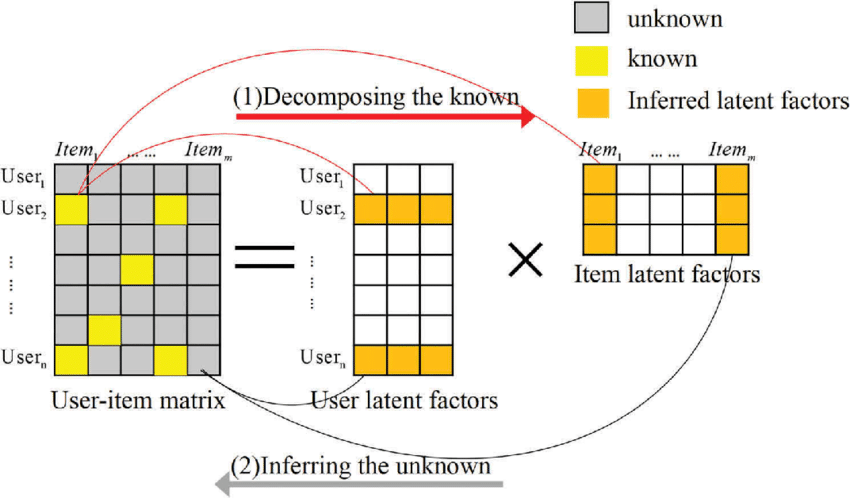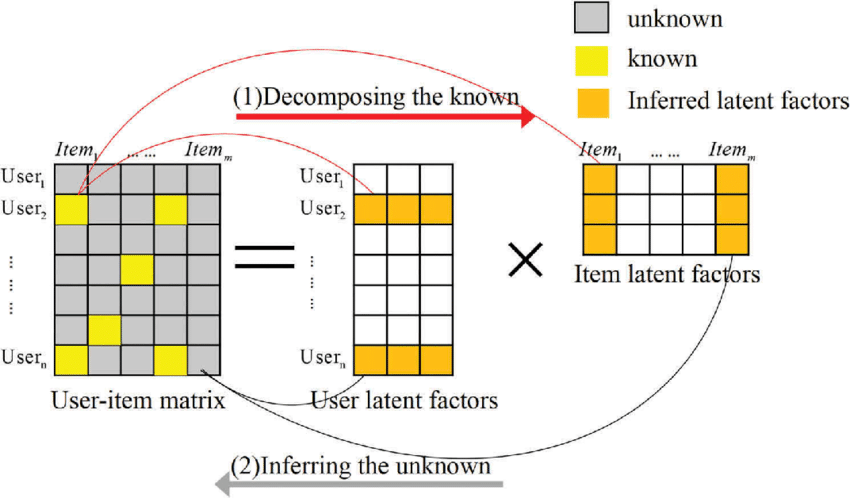![mf.png](mf.png)

In [1]:
(UхI) = (Uхk) * (kхI) 

NameError: name 'Uхk' is not defined

---

## Alternating Least Squares (ALS)

Для explicit

$$L_{exp} = \sum_{(u,i)\in S} (r_{ui} - x_u^T\cdot y_i)^2 + \lambda_x\sum_u\|x_u\|^2 + \lambda_y\sum_i\|y_i\|^2 $$

![als_formula.png](als_formula.png)

$$c_{ui} = 1 +\alpha d_{ui}$$



$x_u^T$ - user embeddings  
$y_i$ - item embeddings  
$p_{ui}$ - 0/1. 1 - если в матрице user-item эдемент > 0 (было взаимодействие)  
$c_{ui}$ - Вес ошибки = элемент матрицы user-item  
$\lambda_x$, $\lambda_y$ - коэффициенты регуляризации  

**Алгоритм**  
ALS - лишь способ оптимизации (поиска коэффициентов в эмбеддингах):  

1. Фиксируем эмбеддинги юзеров $x_u^T$ --> легко посчитать производную по эмбеддингам товаров $y_i$
2. Обновляем эмбеддинги товаров (делаем шаг по антиградиенту = градиентный спуск)
3. Фиксируем эмбеддинги товаров $y_i$ --> легко посчитать производную по эмбеддингам юзеров $x_u^T$
4. Обновляем эмбеддинги юзеров (делаем шаг по антиградиенту = градиентный спуск)
5. Повторяем, пока процедура не сойдется

**Плюсы**
- Очень быстрый
- В продакшене можно зафиксировать на весь день эмбеддинги товаров (товары за день не меняются), 
    и в реал-тайм обновлять эмбеддинги юзеров при покупке
- Есть решуляризация $\lambda_x$, $\lambda_y$
- Есть веса ошибок $с_{u_i}$ - элементы матрицы user-item
- Библиотека implicit под капотом использует Cython - очень быстро работает
- Predict для *всех* юзеров можно сделать прост оперемножением 2-ух матриц - очень быстро
- Можно применять различные **взвешивания** матрицы: TF-IDF, BM25, ... . Это сильно улучшает качество

### 1. Базовое применение

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

In [3]:
data = pd.read_csv('../data/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
item_features = pd.read_csv('../data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [5]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [6]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [7]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [8]:
# Заведем фиктивный item_id (если юзер покупал товары не из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [10]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=sparse_user_item,   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=[itemid_to_id[999999]], 
                        recalculate_user=False)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 17.8 s, sys: 23.1 s, total: 40.9 s
Wall time: 2.67 s


In [11]:
[id_to_itemid[rec] for rec in recs[0]]

[1106523, 1133018, 5569230, 1082185, 1068719]

In [12]:
def get_recommendations(user, model, sparse_user_item, N=5):
    res = [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item[userid_to_id[user]],   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)[0]]
    return res

In [13]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(recommended_list, bought_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision


In [14]:
%%time
    
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: user 1min, sys: 1min 39s, total: 2min 39s
Wall time: 10 s


0.1811949069539667

In [15]:
result.head(2)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1105488, 1033142, 5569374, 979707, 995242]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 1133018, 910032, 5569327, 1022003]"


### Embeddings

In [16]:
model.item_factors.shape

(5001, 100)

In [17]:
model.user_factors.shape

(2499, 100)

Можно очень быстро посчитать предсказания, перемножив эти 2 матрицы

In [18]:
fast_recs = model.user_factors @ model.item_factors.T 
fast_recs.shape

(2499, 5001)

In [19]:
fast_recs[:10,:10]

array([[-0.01179245,  0.13040958, -0.00923958, -0.04875283,  0.00836034,
         0.00658242,  0.00153462,  0.29688787,  0.14692096, -0.01351394],
       [-0.00321669,  0.04310147, -0.01970342, -0.00486259, -0.00795472,
        -0.00871165, -0.00905017,  0.03405887,  0.06311134, -0.03449995],
       [-0.02071019, -0.09817713, -0.03182272, -0.04432371, -0.01690613,
        -0.01597052, -0.01625405,  0.02600597, -0.03923363,  0.13999332],
       [ 0.00814281,  0.06411236,  0.0451124 ,  0.04307934,  0.00278412,
         0.01317435, -0.007959  ,  0.13205895,  0.04558388,  0.01732016],
       [ 0.00164017,  0.03567229, -0.01410376,  0.03690461,  0.00347278,
        -0.00051328, -0.00339479,  0.01016978,  0.05901207,  0.00660824],
       [ 0.00157171,  0.00673115,  0.03643073, -0.01648119, -0.00618921,
        -0.00063947, -0.00429114,  0.08396753, -0.02941776, -0.00042311],
       [ 0.00758218, -0.06943502, -0.04608704,  0.01478237,  0.00331234,
        -0.00932132,  0.00817778,  0.02287956

In [20]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [21]:
model.item_factors.shape

(5001, 100)

In [22]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

/home/alexxl/Documents/GeekBrains/RecSys/venv2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


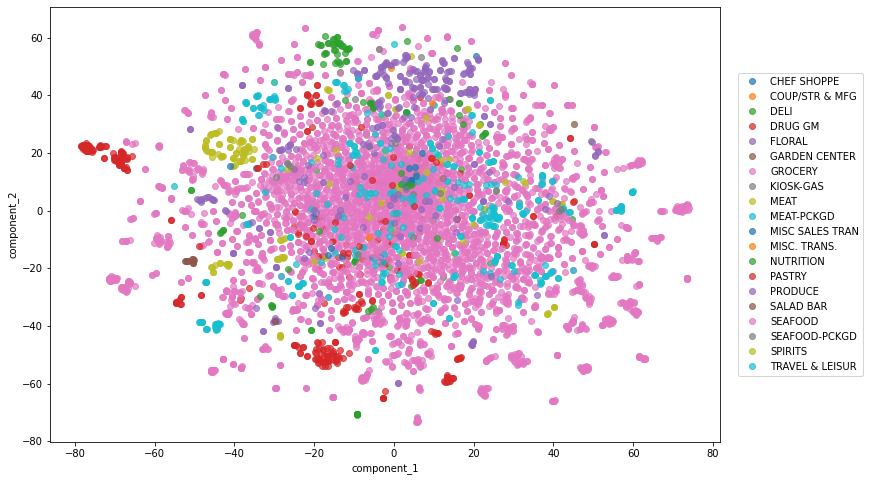

CPU times: user 2min 1s, sys: 2.33 s, total: 2min 4s
Wall time: 8.21 s


In [23]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne') # 5001 х 100  ---> 5001 x 2
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

Нарисуем все, кроме GROCERY

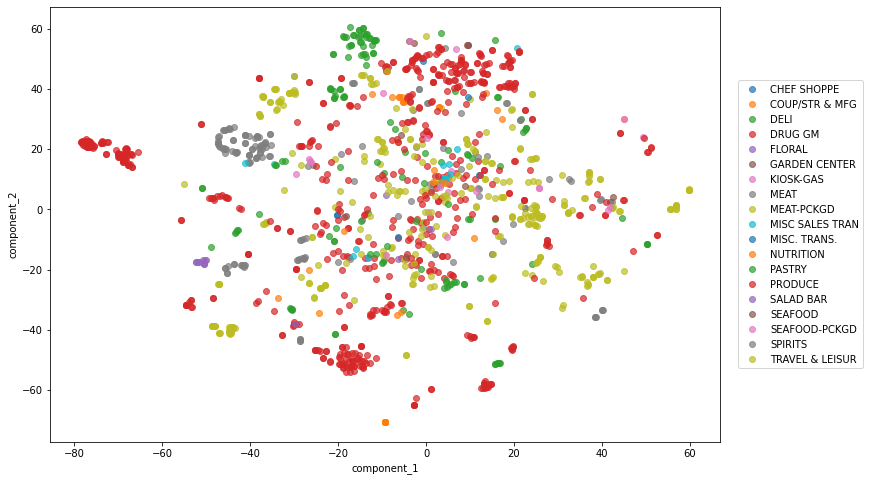

In [24]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

Нарисуем несколько конкретных категорий

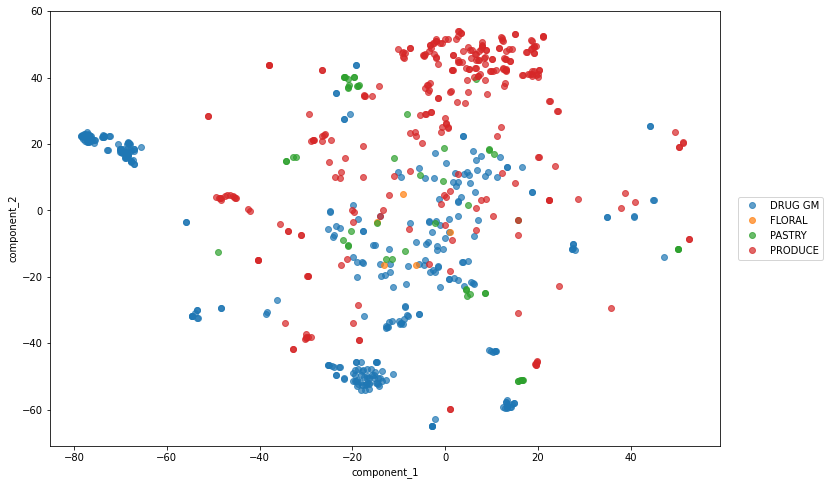

In [25]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

На самом деле, я бы сказал, что **результат средний**:
- Модель выучила похожесть только небольшой части товаров

In [26]:
item_emb_tsne.head(2)

,component_1,component_2,category
0,3.097311,8.277145,MISC SALES TRAN
1,5.621603,12.789966,KIOSK-GAS


recommend_all делает перемножение, но еще и сортирует и выбирает топ-N

In [27]:
%%time
recommendations = model.recommend_all(N=5, 
                                      user_items=sparse_user_item,
                                      filter_already_liked_items=True, 
                                      filter_items=[itemid_to_id[999999]], 
                                      recalculate_user=True)

CPU times: user 1.8 s, sys: 2.33 s, total: 4.12 s
Wall time: 381 ms


In [28]:
item_1 = model.item_factors[1]
item_2 = model.item_factors[2]

*Посмотрите также / Похожие товары*

In [29]:
model.similar_items(1, N=5)

(array([   1,    2, 3932,    5, 4257], dtype=int32),
 array([1.0000001 , 0.7549321 , 0.7398863 , 0.7374581 , 0.72608024],
       dtype=float32))

*Вашим друзьям нравится / Похожим пользователям нравится / ...*

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [30]:
model.similar_users(userid_to_id[10], N=5)

(array([   9,  239,  354,  790, 1380], dtype=int32),
 array([0.99999994, 0.9754858 , 0.9739281 , 0.9734134 , 0.9719732 ],
       dtype=float32))

In [31]:
userid_to_id[10]

9

### 2. TF-IDF взвешивание

In [32]:
tfidf_user_item_matrix = tfidf_weight(user_item_matrix).tocsr() # Применяется к item-user матрице ! 

In [33]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.01,
                                iterations=10, 
                                calculate_training_loss=True, 
                                num_threads=4,
                                random_state=42)

model.fit(tfidf_user_item_matrix,  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 42.3 s, sys: 1min, total: 1min 42s
Wall time: 6.54 s


0.2031341821743389

### 3. BM25 взвешивание

In [34]:
bm25_user_item_matrix = bm25_weight(user_item_matrix.T).T.tocsr() # Применяется к item-user матрице ! 

In [35]:
%%time

model = AlternatingLeastSquares(factors=200, 
                                regularization=0.01,
                                iterations=13, 
                                calculate_training_loss=True, 
                                num_threads=4,
                                random_state=42) # K - кол-во билжайших соседей

model.fit(csr_matrix(bm25_user_item_matrix).tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))

result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()

  0%|          | 0/13 [00:00<?, ?it/s]

CPU times: user 7min 1s, sys: 14min 15s, total: 21min 17s
Wall time: 1min 22s


0.2301665034280118

## 4. Важно искать оптимальные параметры

- regularization, iterations
- factors
- Вес (элемент в матрице user-item)

-----